In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [6]:
!ls

LICENSE    env.yml	 examples  notebooks
README.md  env_norl.yml  mypy.ini  sustaingym


In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv



from sustaingym.envs.battery.MO_single_agent_battery_storage_env import BatteryStorageInGridEnv

In [7]:
def training_results(folder):
    results = []
    fname = f'examples/{folder}/evaluations.npz'
    x = np.load(fname, allow_pickle=True)
    results.append(x['results'])

    timesteps = x['timesteps']
    results = np.hstack(results)
    y = results.mean(axis=1)
    error = results.std(axis=1)
    return timesteps, y, error

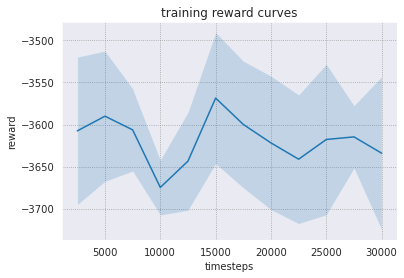

In [8]:
timesteps, y, error = training_results('logs')
plt.plot(timesteps, y)
plt.fill_between(timesteps, y-error, y+error, alpha=0.2)

# timesteps, y, error = training_results(('summer2021', 'ppo'))
# plt.plot(timesteps, y, label='in dist')
# plt.fill_between(timesteps, y-error, y+error, alpha=0.2)

plt.title('training reward curves')

plt.ylabel('reward')
plt.xlabel('timesteps')
# plt.legend()
plt.show()